<a href="https://colab.research.google.com/github/himanshu-tawra/COVID-19-Detector-Flask-App-from-Chest-X-ray-Images-with-Keras-and-Deep-Learning/blob/master/VGG16_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://www.dropbox.com/sh/c2uaggwlb2hosof/AABAu2Uv3u81izc4rWk9zxgna?dl=0

--2020-11-04 16:25:53--  https://www.dropbox.com/sh/c2uaggwlb2hosof/AABAu2Uv3u81izc4rWk9zxgna?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.1, 2620:100:601a:1::a27d:701
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/c2uaggwlb2hosof/AABAu2Uv3u81izc4rWk9zxgna [following]
--2020-11-04 16:25:53--  https://www.dropbox.com/sh/raw/c2uaggwlb2hosof/AABAu2Uv3u81izc4rWk9zxgna
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc48f5e9d5f4872c5bcaf34b9f03.dl.dropboxusercontent.com/zip_download_get/Al-HGXg16RXuoDHjoYBg7L71hPFiD2LPCG0IPLFVXqeC3T71WLgtcsrR4dZ_f_0IxU44MoB5k3S4oVhvNyY6JJFJeYp1ifLMiegeRRnsRN1EOQ [following]
--2020-11-04 16:25:54--  https://uc48f5e9d5f4872c5bcaf34b9f03.dl.dropboxusercontent.com/zip_download_get/Al-HGXg16RXuoDHjoYBg7L71hPFiD2LPCG0IPLFVXqeC3T71WLgtcsrR4dZ_f_0IxU44MoB5k3S4oVhvNyY6

In [3]:
!unzip AABAu2Uv3u81izc4rWk9zxgna?dl=0

Archive:  AABAu2Uv3u81izc4rWk9zxgna?dl=0
mapname:  conversion of  failed
   creating: Val/
   creating: Test/
   creating: Train/
   creating: Val/Covid/
   creating: Test/Covid/
   creating: Val/Normal/
   creating: Train/Covid/
   creating: Test/Normal/
   creating: Train/Normal/
 extracting: Train/Covid/AR-2.jpg    
 extracting: Train/Covid/AR-1.jpg    
 extracting: Test/Covid/paving.jpg   
 extracting: Val/Covid/d009d61f.jpg  
 extracting: Val/Covid/e1446fe8.jpg  
 extracting: Val/Covid/d9d6ca9a.jpg  
 extracting: Val/Covid/f6d980a0.jpg  
 extracting: Val/Covid/ec083e35.jpg  
 extracting: Test/Covid/f8335316.jpg  
 extracting: Test/Covid/f6575117.jpg  
 extracting: Test/Covid/f64132c8.jpg  
 extracting: Train/Covid/5782ae15.jpg  
 extracting: Train/Covid/bb0e626a.jpg  
 extracting: Train/Covid/82a78c13.jpg  
 extracting: Train/Covid/a361d7b7.jpg  
 extracting: Train/Covid/1052b0fe.jpg  
 extracting: Train/Covid/a2eba651.jpg  
 extracting: Train/Covid/bd10d5e2.jpg  
 extracting: Tra

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input,VGG16
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
import os

In [5]:
IMAGE_SIZE = [224,224]

In [6]:
vgg = VGG16(input_shape= IMAGE_SIZE + [3] , weights='imagenet',include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [7]:
for layer in vgg.layers:
  layer.trainable = False

In [8]:
vgg_output = vgg.output

In [9]:
flatten = Flatten()(vgg_output)
dense_layer1 = Dense(activation= 'relu',units=256)(flatten)
dropout_1 = Dropout(rate = 0.5)(dense_layer1)
dense_layer2 = Dense(activation = 'relu',units = 128)(dropout_1)
dropout_2 = Dropout(rate = 0.3)(dense_layer2)
output_layer = Dense(2,activation='softmax')(dropout_2)

In [10]:
model = Model(inputs = vgg.input,outputs = output_layer)

In [11]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [12]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [13]:
training_data_gen = ImageDataGenerator(
    rescale = 1./255.,
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True
)

In [14]:
val_data_gen = ImageDataGenerator(
    rescale = 1./255.
)

In [15]:
training_set = training_data_gen.flow_from_directory(
    'Train/',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
)

Found 251 images belonging to 2 classes.


In [16]:
val_set = val_data_gen.flow_from_directory(
    'Val/',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
)

Found 70 images belonging to 2 classes.


In [17]:
r = model.fit(
    training_set,
    epochs = 5,
    validation_data = val_set,
    validation_steps = len(val_set),
    steps_per_epoch = len(training_set)
    
)

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 1.0111 - accuracy: 0.7211 - val_loss: 0.0201 - val_accuracy: 1.0000
Epoch 2/5
8/8 [==============================] - 9s 1s/step - loss: 0.2482 - accuracy: 0.9283 - val_loss: 0.0226 - val_accuracy: 1.0000
Epoch 3/5
8/8 [==============================] - 9s 1s/step - loss: 0.1839 - accuracy: 0.9442 - val_loss: 3.8079e-05 - val_accuracy: 1.0000
Epoch 4/5
8/8 [==============================] - 9s 1s/step - loss: 0.1140 - accuracy: 0.9641 - val_loss: 1.6896e-05 - val_accuracy: 1.0000
Epoch 5/5
8/8 [==============================] - 9s 1s/step - loss: 0.0915 - accuracy: 0.9761 - val_loss: 3.5896e-06 - val_accuracy: 1.0000


In [37]:
test_pred = []
test_actual = []
counter = 0

In [38]:
directory = 'Test/Covid/'
for filename in os.listdir(directory):
  filepath = os.path.join(directory, filename)
  counter += 1
  print(counter)

  test_image = image.load_img(filepath,target_size = (224,224))
  img_array = image.img_to_array(test_image)

  img_array = np.expand_dims(img_array , axis = 0)
  img_data = img_array/255.
  myclass = model.predict(img_data)
  label_dict = {
       0 : 'Covid',
       1 : 'Normal'
  }
  prediction = label_dict[myclass.argmax()]
  test_pred.append(prediction)
  test_actual.append('Covid')
    #if filename.endswith(".jpg") or filename.endswith(".png"):
      


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [39]:
directory = 'Test/Normal/'
for filename in os.listdir(directory):
  filepath = os.path.join(directory, filename)
  counter += 1
  print(counter)

  test_image = image.load_img(filepath,target_size = (224,224))
  img_array = image.img_to_array(test_image)

  img_array = np.expand_dims(img_array , axis = 0)
  img_data = img_array/255.
  myclass = model.predict(img_data)
  label_dict = {
       0 : 'Covid',
       1 : 'Normal'
  }
  prediction = label_dict[myclass.argmax()]
  test_pred.append(prediction)
  test_actual.append('Normal')
    #if filename.endswith(".jpg") or filename.endswith(".png"):
      


36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


In [40]:
from sklearn.metrics import confusion_matrix

In [41]:
cm = confusion_matrix(test_pred,test_actual)

In [42]:
print(cm)

[[35  0]
 [ 0 35]]


In [43]:
import seaborn as sns

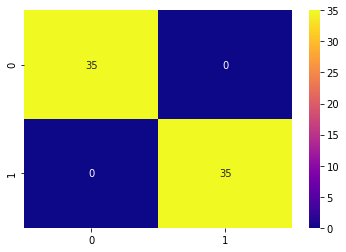

In [44]:
sns.heatmap(cm,cmap = 'plasma',annot = True)

In [46]:
from sklearn.metrics import precision_recall_fscore_support

In [49]:
prf = precision_recall_fscore_support(test_actual,test_pred,labels = ['Covid','Normal'])

In [50]:
print(prf)

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([35, 35]))


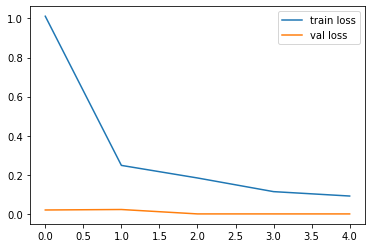

In [51]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'val loss')
plt.legend()
plt.show()

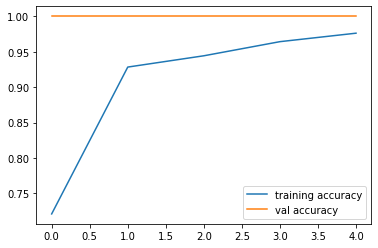

In [52]:
plt.plot(r.history['accuracy'],label = 'training accuracy')
plt.plot(r.history['val_accuracy'],label = 'val accuracy')
plt.legend()
plt.show()